In [1]:
# 📦 Install required packages
!pip install -U transformers
!pip install -q datasets transformers evaluate imbalanced-learn

# 📚 Imports
import gc
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments
from datasets import load_dataset, Dataset, Image, ClassLabel
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from transformers import (AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer)
from torchvision.transforms import (Resize, ToTensor, Normalize, Compose, RandomRotation, RandomAdjustSharpness)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64",

2025-04-19 14:59:12.870353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745074753.102302      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745074753.171407      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Load Dataset & Apply Oversampling

In [2]:
# 📥 Load dataset
dataset = load_dataset('Hemg/deepfake-and-real-images', split='train')

# 🗂️ Extract filenames and labels
file_names, labels = [], []
for example in dataset:
    file_names.append(example['image'].filename)
    labels.append(example['label'])

df = pd.DataFrame({"image": file_names, "label": labels})

# 🔁 Apply random oversampling to balance classes
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df.drop(columns='label'), df[['label']])
df['label'] = y_resampled


README.md:   0%|          | 0.00/394 [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/190335 [00:00<?, ? examples/s]

# 3. Label Mapping + Split Dataset

In [3]:
# 🏷️ Label Mapping
labels_list = ['Real', 'Fake']
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for label, i in label2id.items()}
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# 🔁 Convert labels
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)

# ✂️ Split dataset 60/40
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']


Map:   0%|          | 0/190335 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190335 [00:00<?, ? examples/s]

# 4. Load Swin Transformer + Transforms

In [4]:
# 🧠 Load model & processor
model_name = "microsoft/swin-base-patch4-window7-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels_list),
    ignore_mismatched_sizes=True
)

model.config.id2label = id2label
model.config.label2id = label2id

# 🧪 Image transforms
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

def apply_train_transforms(examples):
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_val_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_data.set_transform(apply_train_transforms)
test_data.set_transform(apply_val_transforms)


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Collator + Metrics + CSV/Plot Export

In [5]:
# 📦 Collator function
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# 📊 Metrics & Export
import evaluate
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    report = classification_report(labels, predictions, target_names=labels_list, output_dict=True)
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    # 📁 Save classification report
    pd.DataFrame(report).transpose().to_csv("classification_report.csv")

    # 📁 Save confusion matrix
    cm = confusion_matrix(labels, predictions)
    cm_df = pd.DataFrame(cm, index=labels_list, columns=labels_list)
    cm_df.to_csv("confusion_matrix.csv")

    # 📊 Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig("confusion_matrix_plot.png")
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


# 6. Training Arguments + Trainer Setup

In [6]:
# ⚙️ Training arguments (Fast for Kaggle)
training_args = TrainingArguments(
    output_dir="./swin-deepfake-fast",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=2,  # Reduce for speed
    learning_rate=1e-5,
    weight_decay=0.01,
    save_strategy='epoch',
    eval_strategy='epoch',
    logging_strategy='no',
    report_to="none",
    remove_unused_columns=False
)

# 🤖 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    processing_class=processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)


# 7. Train and Evaluate

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.067595,0.976922,0.977264,0.976922,0.976918
2,No log,0.054774,0.982124,0.982316,0.982124,0.982122


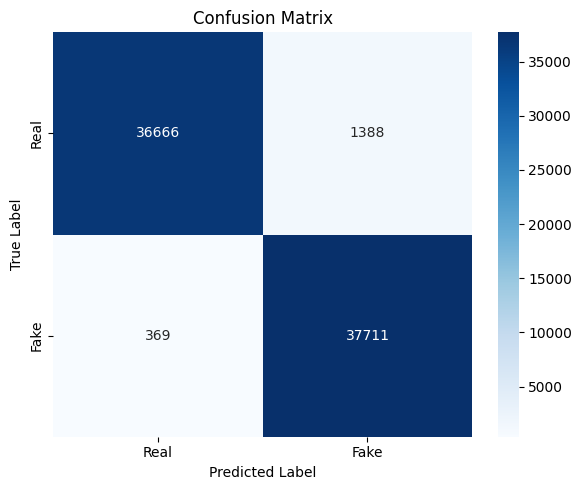

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


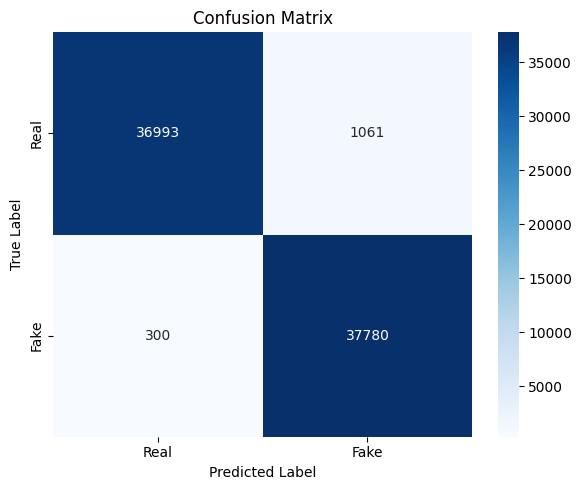

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


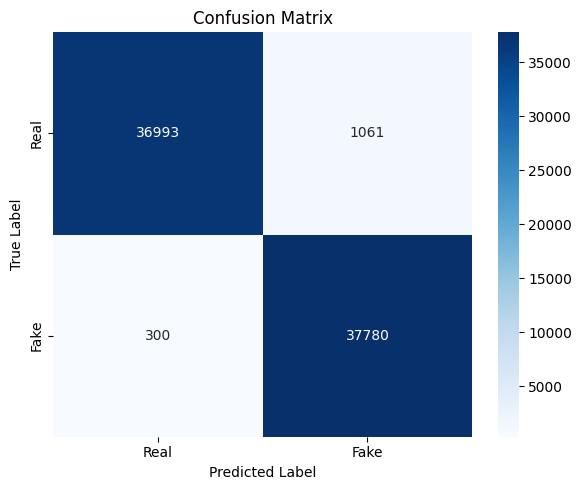

{'eval_loss': 0.05477437749505043,
 'eval_accuracy': 0.9821236241363911,
 'eval_precision': 0.9823162589742878,
 'eval_recall': 0.9821236241363911,
 'eval_f1': 0.9821217768765889,
 'eval_runtime': 849.81,
 'eval_samples_per_second': 89.589,
 'eval_steps_per_second': 5.6,
 'epoch': 2.0}

In [7]:
# 🚀 Train the model
trainer.train()

# 🧪 Evaluate
trainer.evaluate()

# 8. Save Model for FastAPI

In [8]:
# Save model for FastAPI or reuse
model.save_pretrained("swin-model")
processor.save_pretrained("swin-model")

['swin-model/preprocessor_config.json']

In [9]:
ls swin-deepfake-fast/

checkpoint-3569/  checkpoint-7138/


In [10]:
from transformers import SwinForImageClassification

# Manually load model from last checkpoint
model = SwinForImageClassification.from_pretrained("./swin-deepfake-fast/checkpoint-3569")


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.048679,0.984882,0.984927,0.984882,0.984882
2,No log,0.042548,0.986708,0.986727,0.986708,0.986707


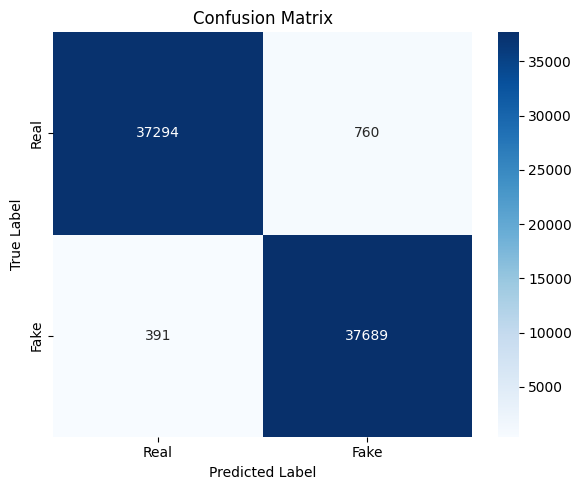

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


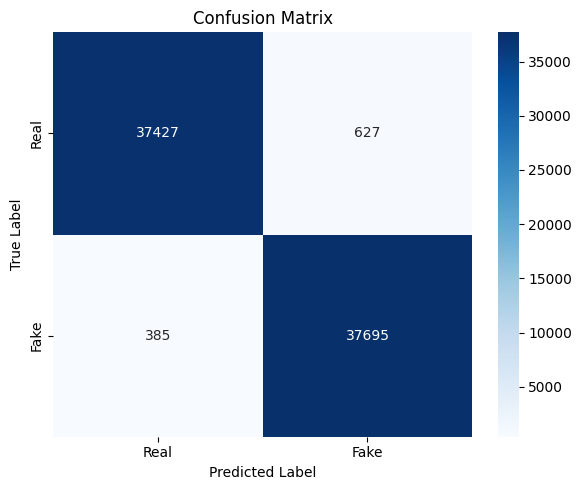

TrainOutput(global_step=7138, training_loss=0.053877129612198794, metrics={'train_runtime': 7480.9611, 'train_samples_per_second': 30.531, 'train_steps_per_second': 0.954, 'total_flos': 1.7894281596553765e+19, 'train_loss': 0.053877129612198794, 'epoch': 2.0})

In [11]:
trainer.train()

# 8. Add Logging & Plotting Enhancements

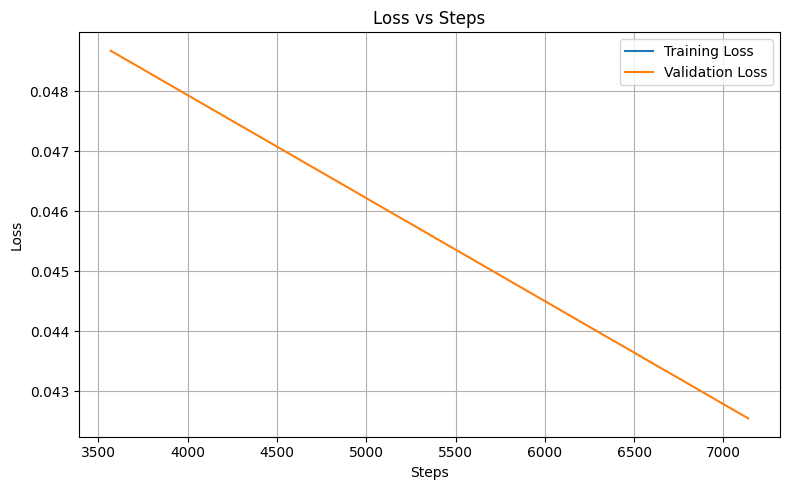

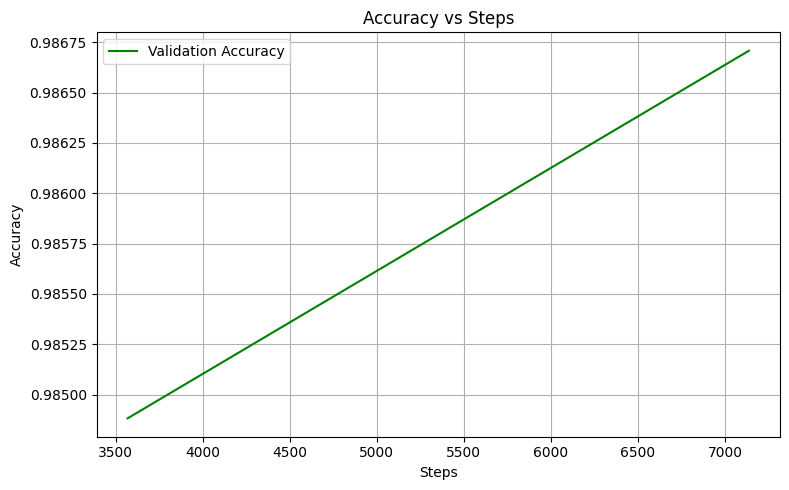

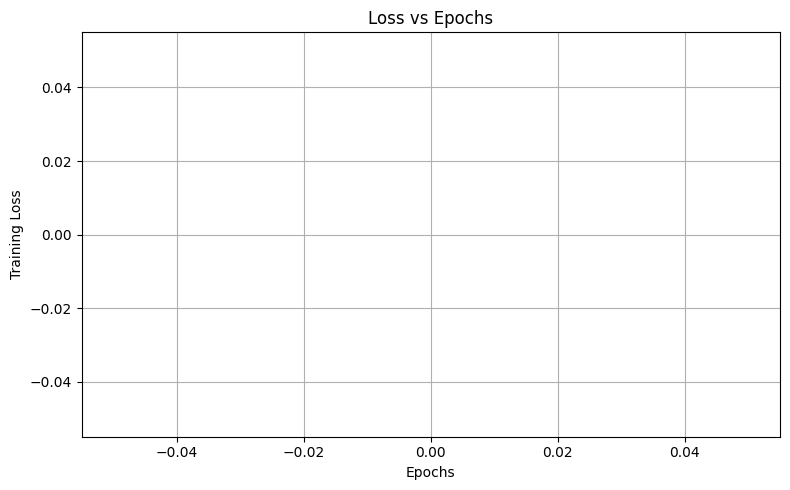

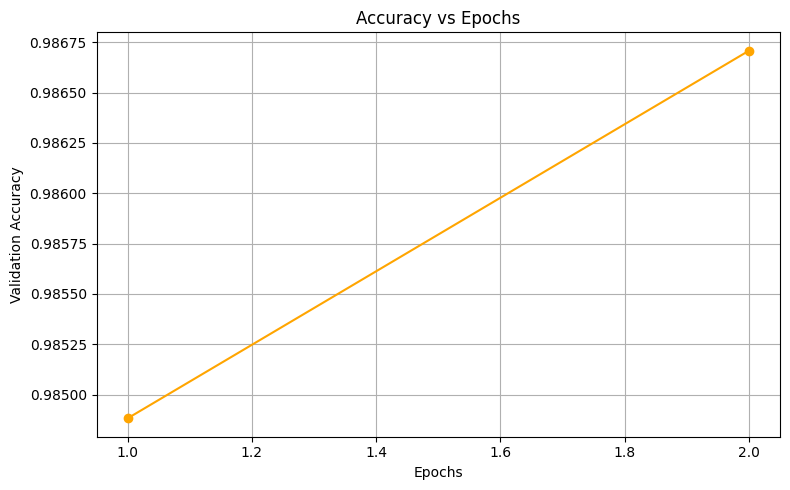

In [12]:
# 📈 Extract and plot metrics from Trainer's log history
logs = trainer.state.log_history

# Extract step, epoch, loss, eval_loss, accuracy, time
steps, epochs, loss, eval_loss, accuracy, timestamps = [], [], [], [], [], []

for entry in logs:
    if 'loss' in entry:
        loss.append(entry['loss'])
        steps.append(entry.get('step', None))
        epochs.append(entry.get('epoch', None))
        timestamps.append(entry.get('timestamp', None))
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        accuracy.append(entry.get('eval_accuracy', None))
        steps.append(entry.get('step', None))
        epochs.append(entry.get('epoch', None))
        timestamps.append(entry.get('timestamp', None))

# 🟦 Loss vs Steps
plt.figure(figsize=(8,5))
plt.plot(steps[:len(loss)], loss, label='Training Loss')
if eval_loss: plt.plot(steps[-len(eval_loss):], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_vs_steps.png")
plt.show()

# 🟩 Accuracy vs Steps
if accuracy:
    plt.figure(figsize=(8,5))
    plt.plot(steps[-len(accuracy):], accuracy, color='green', label='Validation Accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Steps')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_vs_steps.png")
    plt.show()

# 🟪 Loss vs Epochs
if epochs:
    epoch_loss = {}
    for e, l in zip(epochs, loss):
        if e is not None:
            epoch_loss.setdefault(e, []).append(l)
    avg_epoch_loss = {e: np.mean(l) for e, l in epoch_loss.items()}

    plt.figure(figsize=(8,5))
    plt.plot(avg_epoch_loss.keys(), avg_epoch_loss.values(), marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Loss vs Epochs')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_vs_epochs.png")
    plt.show()

# 🟨 Accuracy vs Epochs
if epochs and accuracy:
    epoch_acc = {}
    for e, a in zip(epochs[-len(accuracy):], accuracy):
        if e is not None:
            epoch_acc.setdefault(e, []).append(a)
    avg_epoch_acc = {e: np.mean(a) for e, a in epoch_acc.items()}

    plt.figure(figsize=(8,5))
    plt.plot(avg_epoch_acc.keys(), avg_epoch_acc.values(), marker='o', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_vs_epochs.png")
    plt.show()


In [13]:
# Save model for FastAPI or reuse
model.save_pretrained("swin-model")
processor.save_pretrained("swin-model")

['swin-model/preprocessor_config.json']